<img src ="Images/GatorGlaciologyLogo-01.jpg" width="100" align = "right">

# Experimental Variogram
#### Gator Glaciology Lab, University of Florida

In this notebook, we compute the experimental variogram for a sample area in Greenland to quantify the topographic spatial relationships. Variograms are useful for examining spatial continuity, performing kriging interpolations, and generating stochastic realizations.

We use the SciKit-GStat package for computing variograms. See the documentation (https://scikit-gstat.readthedocs.io/en/latest/) for detailed information on this package.

In [1]:
# load dependencies
import numpy as np
import pandas as pd
import skgstat as skg
from sklearn.preprocessing import QuantileTransformer
import matplotlib.pyplot as plt
import GStatSim as gs

# plot utility functions
from plot_utils import splot2D, make_colorbar

## Load and plot data

Load in bed topography measurements from sample area in Greenland. We use radar bed picks from CReSIS. The coordinates are polar stereographic coordinates.

In [2]:
df_bed = pd.read_csv('Data/greenland_test_data.csv')

# remove erroneously high values due to bad bed picks
df_bed = df_bed[df_bed['Bed'] <= 700]
df_bed.head()

,X,Y,Bed
0,-220370.0,-1650000.0,238.31
1,-220370.0,-1650200.0,237.84
2,-220370.0,-1650300.0,234.70
3,-220370.0,-1650400.0,224.55
4,-220370.0,-1650600.0,212.69


In [3]:
print(f'The data length is {len(df_bed)}')

The data length is 487814


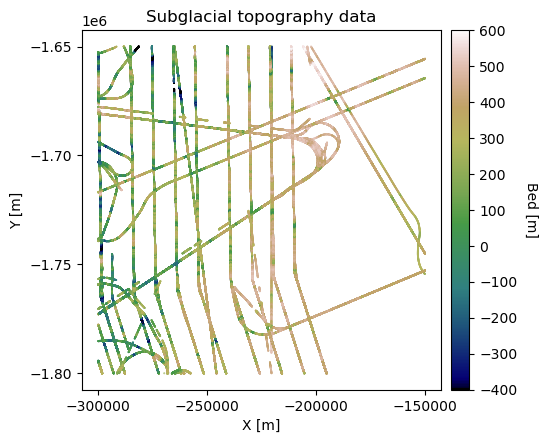

In [4]:
# use convenience plotting function
splot2D(df=df_bed, title='Subglacial topography data')

Grid data to the desired simulation resolution. This is important because the resolution of the data affects the spatial statistics. We recommend gridding the data to the resolution at which you will be performing the interpolation.

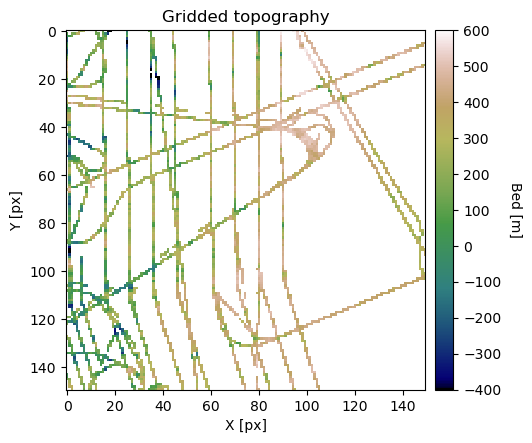

In [5]:
# grid data to 1000 m resolution
res = 1000  
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(df_bed, 'X', 'Y', 'Bed', res)

# plot gridded bed
fig, ax = plt.subplots(1, figsize=(5,5))
im = plt.imshow(grid_matrix, cmap='gist_earth', vmin=-400, vmax=600, 
                interpolation='none', origin='upper')
plt.title('Gridded topography')
plt.xlabel('X [px]'); plt.ylabel('Y [px]')

# make color bar
cbar = make_colorbar(fig, im, -400, 600, 'Bed [m]')

ax.axis('scaled')
plt.show()

In [6]:
df_grid.X.min(), df_grid.X.max()

(-300000.0, -151000.0)

In [7]:
# remove nans
df_grid = df_grid[df_grid['Z'].isnull() == False]
df_grid.head()

,X,Y,Sum,Count,Z
2,-298000.0,-1800000.0,40895.4700,128.0,319.495859
7,-293000.0,-1800000.0,5920.7880,44.0,134.563364
9,-291000.0,-1800000.0,9127.2200,44.0,207.436818
10,-290000.0,-1800000.0,900.3992,6.0,150.066533
12,-288000.0,-1800000.0,69893.3900,212.0,329.685802


## Compute normal score transformation

Many geostatistical methods require Gaussian assumptions, so we need to perform a normal score transformation to convert to a standard Gaussian distribution (mean = 0, standard deviaton = 1, Gaussian shape). After performing a geostatistical analysis such as kriging, the data is back-transformed to it's original distribution.

In [8]:
# normal score transformation
data = df_grid['Z'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution='normal').fit(data)
df_grid['Nbed'] = nst_trans.transform(data) 

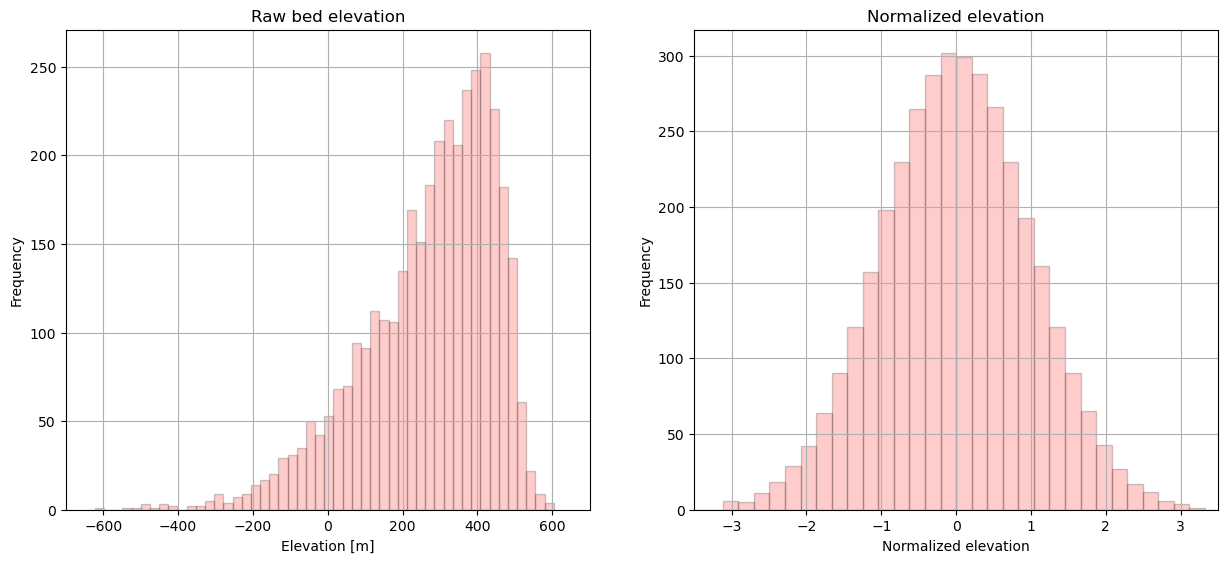

In [9]:
# plot original bed histogram
plt.subplot(121)
plt.hist(df_grid['Z'], facecolor='red', bins=50, alpha=0.2, edgecolor='black')
plt.xlim([-700,700]); 
plt.xlabel('Elevation [m]'); plt.ylabel('Frequency'); plt.title('Raw bed elevation')
plt.grid(True)

# plot normal score bed histogram (with weights)
plt.subplot(122)
plt.hist(df_grid['Nbed'], facecolor='red', bins=50, alpha=0.2, edgecolor='black')
plt.xlim([-3.5,3.5]); 
plt.xlabel('Normalized elevation'); plt.ylabel('Frequency'); plt.title('Normalized elevation')
plt.grid(True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.8, top=1.0, wspace=0.2, hspace=0.3)
plt.show()

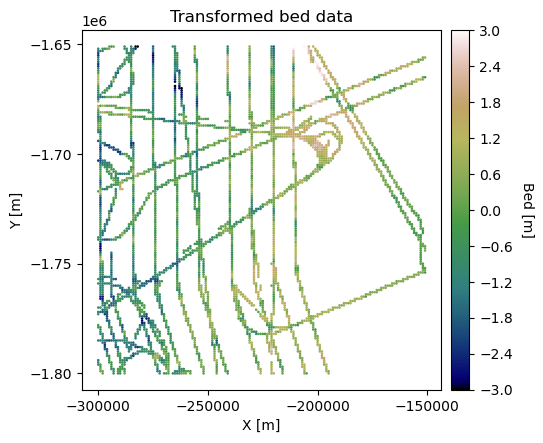

In [10]:
# plot transformed data
splot2D(df=df_grid, title='Transformed bed data', c='Nbed', vmin=-3, vmax=3, s=3)

## Compute Experimental Variogram

The semivariogram, often just referred to as the variogram, is used to qauntify spatial dependence for irregularly spaced data. It computes the average variance of the difference between two data points with a given separation distance, or lag distance $\bf{h}$.

$$
\gamma(\bf{h}) = \frac{1}{2 N(\bf{h})} \sum^{N}_{\alpha=1} (Z(\bf{x}_\alpha) - Z(\bf{x}_\alpha + \bf{h}))^2  
$$


where $\bf{x}$ is a spatial location, $\bf{Z(x)}$ is a variable (e.g. bed elevation), and $\bf{N}$ is the number of lag distances. This can become computationally expensive, so we recommend randomly downsampling for large datasets.

We'll start by computing the isotropic variogram, which averages across different azimuthal directions using the Scikit GStat tools. 

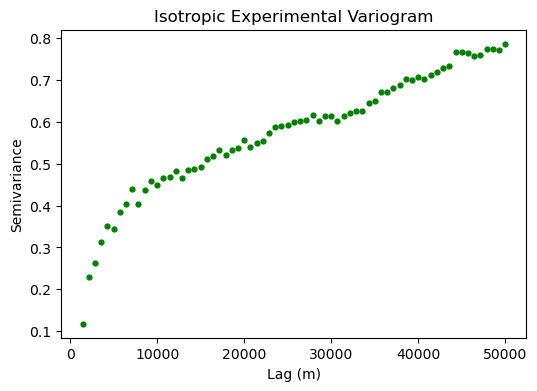

In [11]:
# compute experimental (isotropic) variogram
coords = df_grid[['X','Y']].values
values = df_grid['Nbed']

maxlag = 50000      # maximum range distance
n_lags = 70         # num of bins

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

This plot shows the expected variance between two points as a function of lag distance. So for a lag distance of approximately zero, the variogram is close to zero because two points in the same location should not have much variability. The curve should start leveling out at $\gamma(\bf{h}) = 1$ because our data has undergone a normal score transformation.

Glacial topography is often highly anisotropic. So let's try calculating the variogram for different azimuthal directions.

In [12]:
# directional variogram

V0 = skg.DirectionalVariogram(coords, values, bin_func = "even", n_lags = n_lags, 
                                  maxlag = maxlag, normalize=False, azimuth=0, tolerance=15)

V45 = skg.DirectionalVariogram(coords, values, bin_func = "even", n_lags = n_lags, 
                                  maxlag = maxlag, normalize=False, azimuth=45, tolerance=15)

V90 = skg.DirectionalVariogram(coords, values, bin_func = "even", n_lags = n_lags, 
                                   maxlag = maxlag, normalize=False, azimuth=90, tolerance=15)

V135 = skg.DirectionalVariogram(coords, values, bin_func = "even", n_lags = n_lags, 
                                  maxlag = maxlag, normalize=False, azimuth=135, tolerance=15)

x0 = V0.bins
y0 = V0.experimental

x45 = V45.bins
y45 = V45.experimental

x90 = V90.bins
y90 = V90.experimental

x135 = V135.bins
y135 = V135.experimental

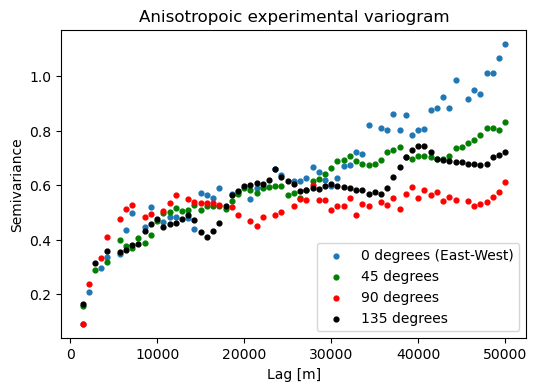

In [13]:
# plot multidirectional variogram
plt.figure(figsize=(6,4))
plt.scatter(x0, y0, s=12, label='0 degrees (East-West)')
plt.scatter(x45, y45,s=12, c='g', label='45 degrees')
plt.scatter(x90, y90, s=12, c='r', label='90 degrees')
plt.scatter(x135, y135, s=12, c='k', label='135 degrees')
plt.title('Anisotropoic experimental variogram')
plt.xlabel('Lag [m]'); plt.ylabel('Semivariance')
plt.legend(loc='lower right')
plt.show()

This shows us how the spatial dependencies vary in different directions. We do not see significant anisotropy in this example at < 30 km lags.

We will also point out that the data gridding process can cause percieved smoothing in the 0 and 90 degree directions. So it could be useful to check the variogram for the non-gridded data to ensure that your interpretation is correct.